In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import skew
from scipy.stats import kurtosis
import scipy.stats as stats
from sklearn import preprocessing
from itertools import combinations
import warnings
import pandas as pd
import missingno as msno
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn.pipeline import Pipeline
from category_encoders.woe import WOEEncoder
from sklearn.preprocessing import OneHotEncoder, RobustScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
warnings.filterwarnings("ignore")


import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))



/kaggle/input/hmeq-data/hmeq.csv


In [2]:
data = pd.read_csv("/kaggle/input/hmeq-data/hmeq.csv")

In [3]:
data_copy = data.copy()
data_copy.head()

,BAD,LOAN,MORTDUE,VALUE,REASON,JOB,YOJ,DEROG,DELINQ,CLAGE,NINQ,CLNO,DEBTINC
0,1,1100,25860.0,39025.0,HomeImp,Other,10.5,0.0,0.0,94.366667,1.0,9.0,NaN
1,1,1300,70053.0,68400.0,HomeImp,Other,7.0,0.0,2.0,121.833333,0.0,14.0,NaN
2,1,1500,13500.0,16700.0,HomeImp,Other,4.0,0.0,0.0,149.466667,1.0,10.0,NaN
3,1,1500,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0,1700,97800.0,112000.0,HomeImp,Office,3.0,0.0,0.0,93.333333,0.0,14.0,NaN


In [4]:
data_copy.shape

(5960, 13)

# Train Test split before pre-processing

In [5]:
#check duplicate
data_copy.duplicated().sum()

0

In [6]:
y = data_copy.pop("BAD")
X = data_copy

In [7]:
#train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size = 0.2)

In [8]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((4768, 12), (4768,), (1192, 12), (1192,))

# Feature engineering

1. drop duplicate
2. impute missing
3. process outliers (robust scaler)
4. encode categorical data

In [9]:
categorical_cols= ['REASON', 'JOB']
numerical_cols= ['LOAN', 'DEBTINC', 'DELINQ', 'MORTDUE', 'YOJ', 'CLNO', 'DEROG', 'CLAGE', 'NINQ', 'VALUE']

In [10]:
#feature engineering for numerical data
num_transformer = Pipeline(
    steps=[("imputer", SimpleImputer(missing_values=np.nan, strategy='median')), ("scaler", RobustScaler())]
)

#feature engineering for categorical data
cat_transformer = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("onehot", OneHotEncoder(handle_unknown="ignore", sparse=False)),
    ]
)
#full training feature engineering
preprocessor = ColumnTransformer(
    transformers=[
        ("num", num_transformer, numerical_cols),
        ("cat", cat_transformer, categorical_cols),
    ]
)

# Model

In [11]:
#full training pipline
clf_logReg = Pipeline(
    steps=[("preprocessor", preprocessor), ("classifier", LogisticRegression())]
)

clf_svm = Pipeline(
    steps=[("preprocessor", preprocessor), ("classifier", svm.SVC(probability=True))]
)

In [12]:
clf_logReg.fit(X_train, y_train)
clf_svm.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   RobustScaler())]),
                                                  ['LOAN', 'DEBTINC', 'DELINQ',
                                                   'MORTDUE', 'YOJ', 'CLNO',
                                                   'DEROG', 'CLAGE', 'NINQ',
                                                   'VALUE']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                           

In [13]:
y_pred = clf_logReg.predict(X_test)
print(f"Accuracy score logistic regression {accuracy_score(list(y_test), list(y_pred))}")

y_pred = clf_svm.predict(X_test)
print(f"Accuracy score svm {accuracy_score(list(y_test), list(y_pred))}")

Accuracy score logistic regression 0.8162751677852349
Accuracy score svm 0.863255033557047


In [14]:
from sklearn.metrics import roc_curve, auc


def plot_roc_curve(model, X_test, y_test):
    y_pred_prob_test = model.predict_proba(X_test)[:, 1]
    fpr, tpr, thres = roc_curve(y_test, y_pred_prob_test)
    roc_auc = auc(fpr, tpr)
    plt.figure(figsize = (10, 8))
    plt.plot(fpr, tpr, 'b-', color='darkorange', lw=2, linestyle='--', label='ROC curve (area = %0.2f)'%roc_auc)
    plt.plot([0, 1], [0, 1], '--')
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc='lower right')
    plt.title('ROC Curve')


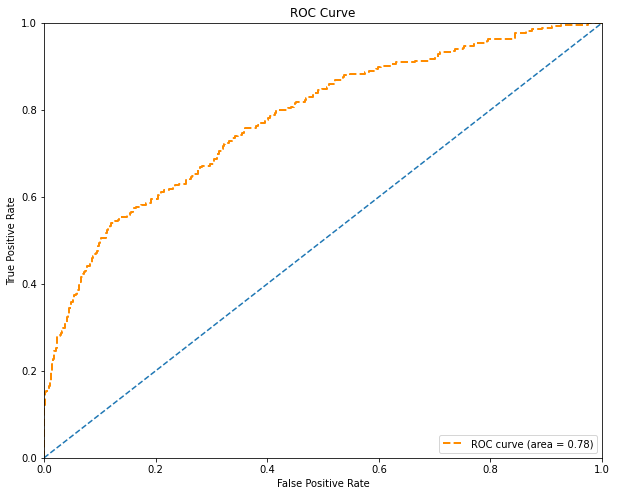

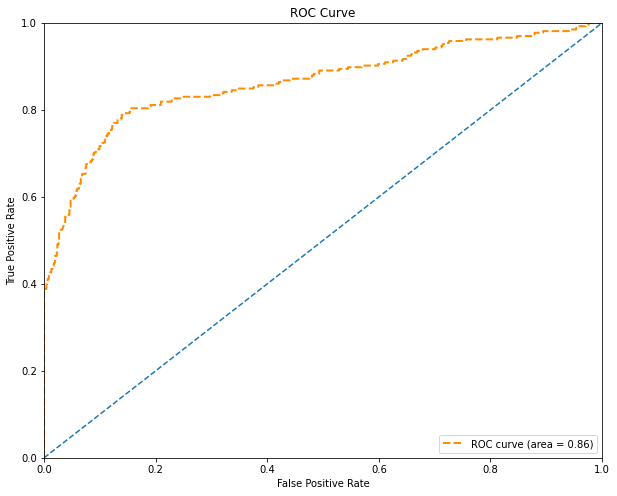

In [15]:
plot_roc_curve(clf_logReg, X_test, y_test)
plot_roc_curve(clf_svm, X_test, y_test)

# Using weight of evidence - IV encoder

In [16]:
data_woe = data.copy()

In [17]:
#remove duplicate
data_woe = data_woe.drop_duplicates()
data_woe.reset_index(drop=True, inplace=True)
data_woe.duplicated().sum()

0

In [18]:
#train test split
y_woe = data_woe.pop("BAD")
X_woe = data_woe
X_train_woe, X_test_woe, y_train_woe, y_test_woe = train_test_split(X_woe, y_woe, random_state=42, test_size=0.2)

In [19]:
X_train_woe.shape, X_test_woe.shape, y_train_woe.shape, y_test_woe.shape

((4768, 12), (1192, 12), (4768,), (1192,))

In [20]:
for col in categorical_cols + numerical_cols:
    woe=WOEEncoder(cols=[col], random_state=42, regularization=1)
        
    X_train_woe['woe_'+col]=woe.fit_transform(X_train_woe[col],y_train_woe)
    X_test_woe['woe_'+col]=woe.transform(X_test_woe[col])

In [21]:
woe_cols = list(X_train_woe.columns)[-12:]
woe_cols

['woe_REASON',
 'woe_JOB',
 'woe_LOAN',
 'woe_DEBTINC',
 'woe_DELINQ',
 'woe_MORTDUE',
 'woe_YOJ',
 'woe_CLNO',
 'woe_DEROG',
 'woe_CLAGE',
 'woe_NINQ',
 'woe_VALUE']

In [22]:
X_train_woe[["LOAN","woe_LOAN"]]

,LOAN,woe_LOAN
944,9100,0.394295
5755,43800,0.325302
2259,13800,-0.310686
12,2000,2.340205
1117,9900,0.325302
...,...,...
3772,20000,0.975890
5191,28000,0.443085
5226,28300,-0.185523
5390,31100,0.325302


In [23]:
clf_logReg_woe = LogisticRegression(random_state=42).fit(X_train_woe[woe_cols[-12:]], y_train_woe)
clf_svm_woe = svm.SVC(probability=True).fit(X_train_woe[woe_cols[-12:]], y_train_woe)

In [24]:
y_pre_logReg_woe = clf_logReg_woe.predict(X_test_woe[woe_cols[-12:]])
y_pre_svm_woe = clf_svm_woe.predict(X_test_woe[woe_cols[-12:]])

In [25]:
print(f"Accuracy score logistic regression {accuracy_score(list(y_test_woe), list(y_pre_logReg_woe))}")
print(f"Accuracy score svm {accuracy_score(list(y_test_woe), list(y_pre_svm_woe))}")

Accuracy score logistic regression 0.8548657718120806
Accuracy score svm 0.8657718120805369


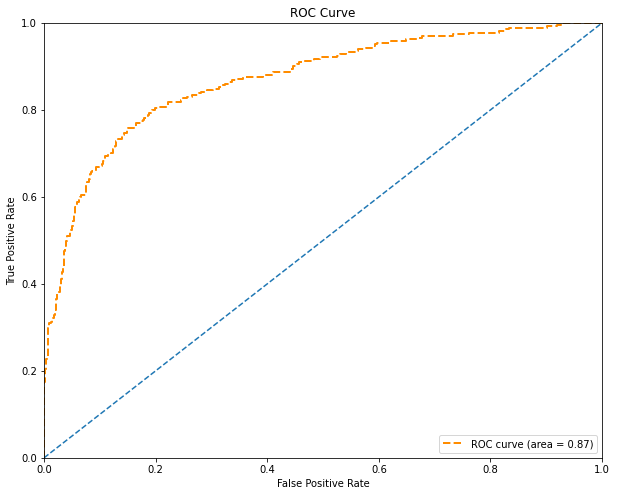

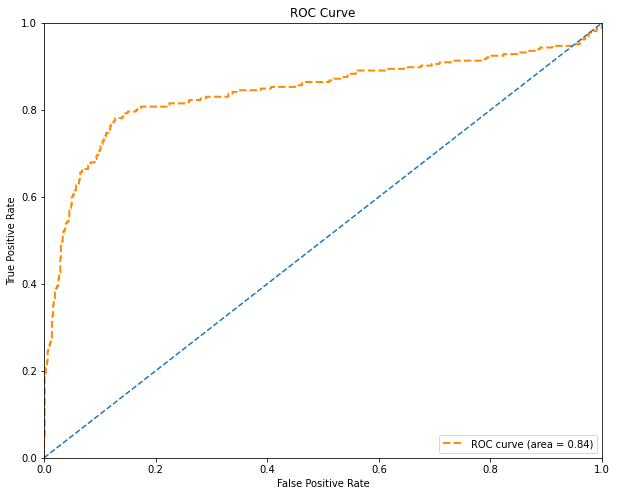

In [26]:
plot_roc_curve(clf_logReg_woe, X_test_woe[woe_cols[-12:]], y_test_woe)
plot_roc_curve(clf_svm_woe, X_test_woe[woe_cols[-12:]], y_test_woe)